In [1]:
#--Simulation settings--
num_rounds = 50 # Number of communication rounds
num_devices = 10 # Number of devices
SNR = 2 #Signal-to-Noise ratio in linear scale (-1 means no noise)
bs = 50 # Batch size for local training at devices
ep = 2 # Number of local epochs before communication round
filename = "SNR-2-devices-10-test-2"

In [2]:
#--Load MNIST dataset--
import tensorflow as tf
import time
import numpy as np

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255, x_test/255

num_samples = len(x_train)

#Split dataset into shards
samples_per_shard = int(num_samples/num_devices)
x_train_shards = []
y_train_shards = []
for i in range(num_devices):
    x_train_shard = x_train[i*samples_per_shard:(i+1)*samples_per_shard]
    x_train_shards.append(x_train_shard)
    y_train_shard = y_train[i*samples_per_shard:(i+1)*samples_per_shard]
    y_train_shards.append(y_train_shard)

print("Dataset loaded.")

Dataset loaded.


In [ ]:
#--Create my own Model subclass--
"""The reason I'm creating my own model class is because the default Sequential model provided
by keras doesn't support extraction of gradients. To do this, I'm overriding the train_step method
and force it to store gradients in a member variable."""
class GradientSequential(tf.keras.Model):
    cum_gradient = 0
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
            #Compute gradients
            trainable = self.trainable_variables
            gradients = tape.gradient(loss, trainable)
            #Store gradients
            print(gradients)
            cum_gradient = cum_gradient + gradients
            #Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable))
            #Update metrics
            self.compiled_metrics.update_state(y, y_pred)
            
            return {m.name: m.result() for m in self.metrics}

In [3]:
#--Set up DNN models--
model_template = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

model_list = []

for i in range(num_devices):
    model_list.append(tf.keras.models.clone_model(model_template))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

for model in model_list:
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [4]:
#--Perform FL--
acc_history = []
for r in range(num_rounds):
    print("Communication round " + str(r+1) + "/" + str(num_rounds))
    start = time.time()
    #Train using local dataset
    for d in range(num_devices): #TODO: Parallelize
        model_list[d].fit(x_train_shards[d], y_train_shards[d], batch_size=bs, epochs=ep, verbose=0)
    #Calculate weight average
    average_weights = model_list[0].get_weights()
    for d in range(num_devices): #This could be done in a faster way
        if d == 0:
            continue
        weights = model_list[d].get_weights()
        for l in range(len(average_weights)):
            average_weights[l] = average_weights[l] + weights[l]
    #When performing averaging, noise is added. I follow BAA for noise power
    for l in range(len(average_weights)):
        if SNR != -1:
            for element in np.nditer(average_weights[l], op_flags = ['readwrite']):
                element[...] = element + np.random.normal(0, np.abs(element)/SNR)
        average_weights[l] = average_weights[l]/num_devices
    
    #Set model of all devices to the average
    for model in model_list:
        model.set_weights(average_weights)
    acc_history.append(model_list[0].evaluate(x_test, y_test, verbose=0)[1])
    print("Current test dataset accuracy: ", acc_history[-1])
    print(str(int(time.time()-start)) + " seconds elapsed\n")

Communication round 1/50
Current test dataset accuracy:  0.6749
11 seconds elapsed

Communication round 2/50
Current test dataset accuracy:  0.8994
8 seconds elapsed

Communication round 3/50
Current test dataset accuracy:  0.9178
7 seconds elapsed

Communication round 4/50
Current test dataset accuracy:  0.9269
7 seconds elapsed

Communication round 5/50
Current test dataset accuracy:  0.9273
8 seconds elapsed

Communication round 6/50
Current test dataset accuracy:  0.9308
7 seconds elapsed

Communication round 7/50
Current test dataset accuracy:  0.9363
7 seconds elapsed

Communication round 8/50
Current test dataset accuracy:  0.9362
8 seconds elapsed

Communication round 9/50
Current test dataset accuracy:  0.9384
7 seconds elapsed

Communication round 10/50
Current test dataset accuracy:  0.9418
7 seconds elapsed

Communication round 11/50
Current test dataset accuracy:  0.9393
8 seconds elapsed

Communication round 12/50
Current test dataset accuracy:  0.9359
8 seconds elapsed



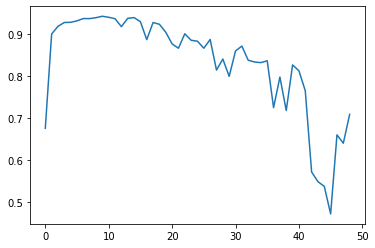

In [5]:
#--Plot accuracy--
import matplotlib.pyplot as plt
start = 0
end = -1
fig = plt.figure()
plt.plot(range(len(acc_history[start:end])), acc_history[start:end])
plt.savefig("./plots/"+filename+".png", format='png')

In [6]:
#--Store history--
np_history = np.asarray(acc_history)
np_history.tofile("./acc_history/"+filename+".txt", sep=',')

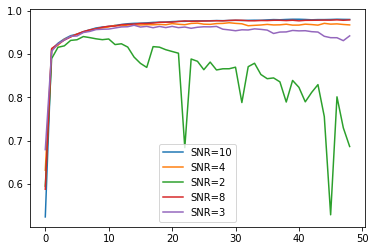

In [7]:
#--Comparative plot
#Get history
filenames = []
filenames.append("SNR-10-devices-10")
filenames.append("SNR-infinity-devices-10")
filenames.append("SNR-4-devices-10")
filenames.append("SNR-2-devices-10")
filenames.append("SNR-8-devices-10")
filenames.append("SNR-3-devices-10")
labels = []
labels.append("SNR=10")
labels.append("SNR=infinity")
labels.append("SNR=4")
labels.append("SNR=2")
labels.append("SNR=8")
labels.append("SNR=3")
histories = []
for i in range(len(filenames)):
    histories.append(np.fromfile("./acc_history/"+filenames[i]+".txt", sep=","))
#Plot
start = 0
end = -1
fig = plt.figure()
for i in range(len(filenames)):
    if labels[i] != "SNR=infinity":
        plt.plot(range(len(histories[i][start:end])), histories[i][start:end], label=labels[i])
plt.legend()
#plt.savefig("./plots/"+filename+".png", format='png')